## Setting up environment

In [3]:
import os
import numpy as np
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from matplotlib import cm
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
from matplotlib.dates import date2num
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch

## Folders and initial files

In [44]:
# Set the directory containing your .nc files
global_folder = 'networks/outputs/solved'
network_folder = 'networks/outputs/solved/LS'

In [31]:
# Calculate difficult periods and netload events
# !NETWORK_FOLDER="{network_folder}" python scripts/difficult_periods.py
# !NETWORK_FOLDER="{network_folder}" python scripts/netload_events.py
# Load the CSV file into a DataFrame
#difficult_periods = pd.read_csv(f"{network_folder}/difficult_periods.csv")
#netload_events = pd.read_csv(f"{network_folder}/netload_events.csv")
os.environ["NETWORK_FOLDER"] = network_folder
%run scripts/difficult_periods.py
%run scripts/netload_events.py

INFO:pypsa.io:Imported network 2002_181_90m_c1.25_Co2L0.0-1H_HT_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_HT_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_HT_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:root:Identified 0 difficult periods.
INFO:pypsa.io:Imported network 2002_181_90m_c1.25_Co2L0.0-1H_HT_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_HT_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_HT_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, 

In [45]:
type_mapping = {
    '_UC': 'unchanged',
    '_SC': 'snapshot changed',
    '_MC': 'mix changed',
    '_LT': 'low transmission',
    '_HT': 'high transmission',
    '_LS': 'low storage',
    '_HS': 'high storage'
}
difficult_periods = pd.read_csv(f"{network_folder}/difficult_periods.csv")
netload_events = pd.read_csv(f"{network_folder}/netload_events.csv")

## Plot: Network Overview

INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_LS_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2002_181_90m_c1.25_Co2L0.0-1H_LS_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_LS_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


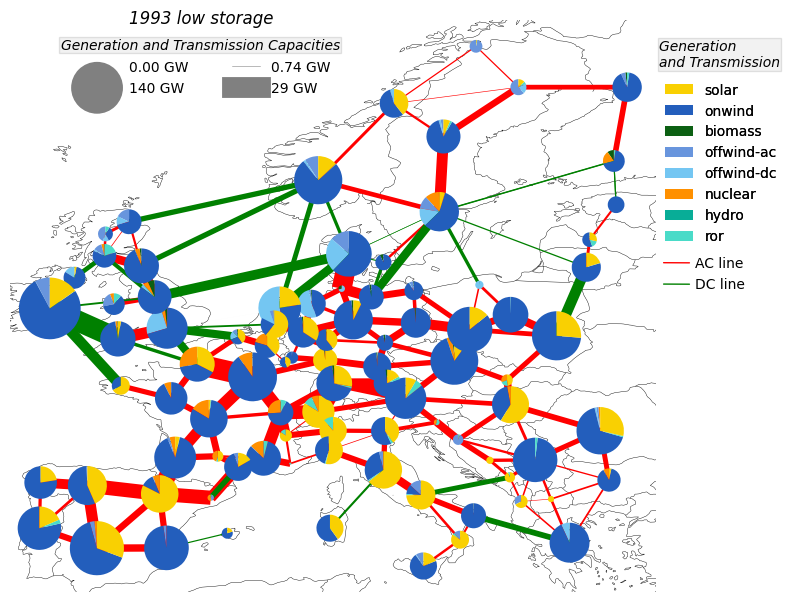

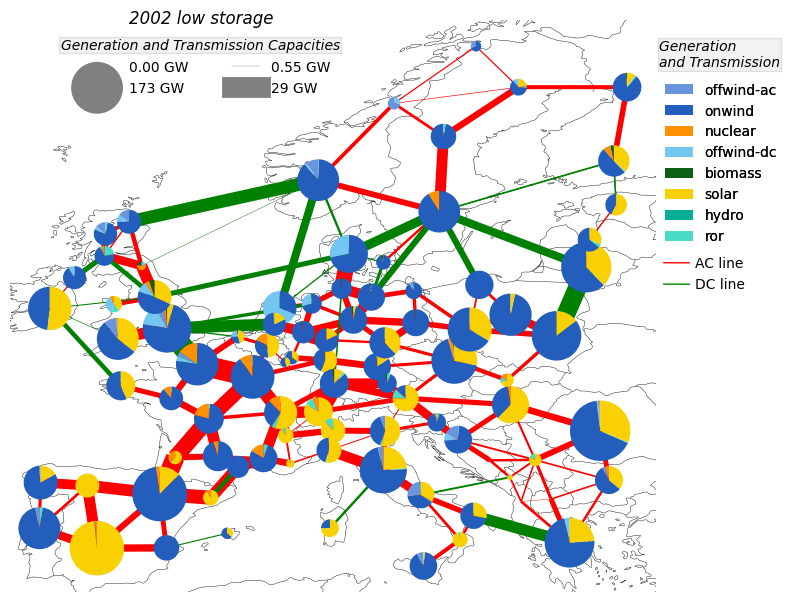

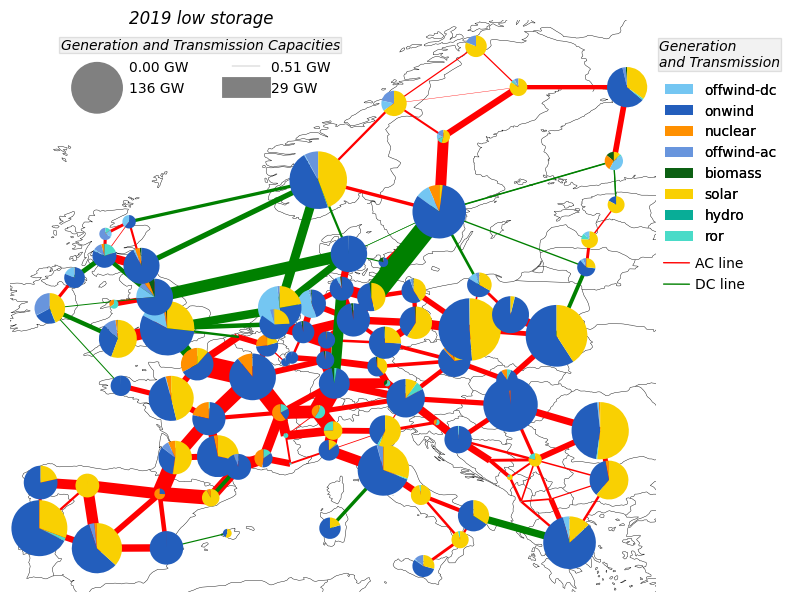

In [46]:
for i, filename in enumerate(sorted(os.listdir(network_folder))):
    if filename.endswith('.nc'):
        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)

        # # WITH STORAGE
        # generator_capacities = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()
        # storage_capacities = n.storage_units.groupby(['bus', 'carrier']).p_nom_opt.sum()
        # total_capacities = generator_capacities.add(storage_capacities, fill_value=0)
        # bus_sizes=total_capacities/50000 

        # Scaling everything to universal level
        scaling_factor = 2.5 / n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().max()
        scaled_bus_sizes = n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum() * scaling_factor
        scaling_factor_lines = 15 / n.lines.s_nom_opt.max()
        scaled_line_sizes = n.lines.s_nom_opt * scaling_factor_lines
        scaling_factor_links = 15 / n.links.p_nom_opt.max()
        scaled_link_sizes = n.links.p_nom_opt * scaling_factor_links
        
        fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, figsize=(8, 8))
        n.plot(ax=ax,
            line_widths=n.lines.s_nom_opt*scaling_factor_lines, line_colors='red',
            link_widths=n.links.p_nom_opt*scaling_factor_links, link_colors='green',
            bus_sizes=n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()*scaling_factor,
            bus_colors=n.carriers.color,
        )
        # Define sizes and labels for the legend
        sizes = [n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().min()*scaling_factor, n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().max()*scaling_factor]
        labels = [f'{n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().min()*1e-3:.2f} GW', f'{n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().max()*1e-3:.0f} GW']
        transmission_sizes = [n.lines.s_nom_opt.min()*scaling_factor_lines, n.lines.s_nom_opt.max()*scaling_factor_lines]
        transmission_labels = [f'{n.lines.s_nom_opt.min()*1e-3:.2f} GW', f'{n.lines.s_nom_opt.max()*1e-3:.0f} GW']
        pypsa.plot.add_legend_circles(ax, sizes, labels, srid=4326, patch_kw=dict(facecolor='grey'), legend_kw={
            'loc': 'center',  # Relative position inside the legend box
            'bbox_to_anchor': (0.2, 0.9),  # Coordinates of the legend box's corner relative to the axes
            #'title': 'Generation and Transmission Capacity',
            'frameon': False
        })
        pypsa.plot.add_legend_lines(ax, transmission_sizes, transmission_labels, patch_kw=dict(color='grey'), legend_kw={
            'loc': 'center',  # Relative position inside the legend box
            'bbox_to_anchor': (0.42, 0.9),  # Coordinates of the legend box's corner relative to the axes
            #'title': 'Transmission Capacity',
            'frameon': False
        })
        # Exclude specific carriers from the legend
        excluded_carriers = ['PHS', 'H2', 'battery']
        filtered_colors = n.carriers.loc[~n.carriers.index.isin(excluded_carriers), 'color']
        filtered_labels = n.carriers.index[~n.carriers.index.isin(excluded_carriers)]

        pypsa.plot.add_legend_patches(ax, colors=filtered_colors, labels=filtered_labels, patch_kw={}, legend_kw={
            'loc': 'center',  # Relative position inside the legend box
            'bbox_to_anchor': (1.1, 0.75),  # Coordinates of the legend box's corner relative to the axes
            #'title': 'Transmission Capacity',
            'frameon': False,
            'ncol': 1
        })
        
        for key, value in type_mapping.items():
            if key in filename:
                type = value
                name = f'{filename[0:4]} {type}'
                shortname = f'{filename[0:4]}{key}'
                break
        
        ax.text(
            -3, 69.5,  # Example longitude, latitude
            f'{name}', 
            style='oblique',
            fontsize=12,
            #bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 1},
            transform=ccrs.PlateCarree()  # Ensure text is plotted in geographic coordinates
        )
        ax.text(
            -7, 68,  # Example longitude, latitude
            'Generation and Transmission Capacities', 
            style='italic',
            bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 1},
            transform=ccrs.PlateCarree()  # Ensure text is plotted in geographic coordinates
        )
        ax.text(
            28, 67,  # Example longitude, latitude
            'Generation \nand Transmission', 
            style='italic',
            bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 1},
            transform=ccrs.PlateCarree()  # Ensure text is plotted in geographic coordinates
        )
        ax.annotate('AC line', xy=(28.1, 55.5), xytext=(30.1, 55.25), fontsize=10,
                    arrowprops=dict(color='red', arrowstyle='-'),
            transform=ccrs.PlateCarree())
        ax.annotate('DC line', xy=(28.1, 54.25), xytext=(30.1, 54), fontsize=10,
                    arrowprops=dict(color='green', arrowstyle='-'),
            transform=ccrs.PlateCarree())
        
        plt.tight_layout()
        # Show the plot
        plt.savefig(f'figures/network_overview_{shortname}.png')
        #plt.close()
        #plt.show()

## Plot: Nodal price, Load, Generation & Storage Timeseries

In [10]:
print(n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum())

bus    carrier   
AL0 0  offwind-ac       0.030119
       onwind           0.048383
       ror             48.200000
       solar         7213.827764
AT0 0  onwind           0.153422
                        ...     
SI0 0  solar            0.505992
SK0 0  nuclear       1940.000000
       onwind           0.079281
       ror           1363.460000
       solar            2.587188
Name: p_nom_opt, Length: 427, dtype: float64


INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2002_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


No difficult period found for file: 2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc


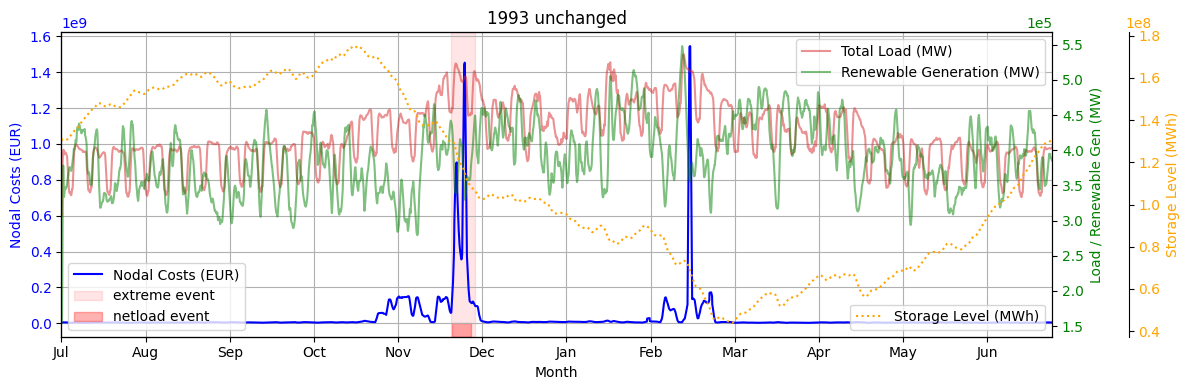

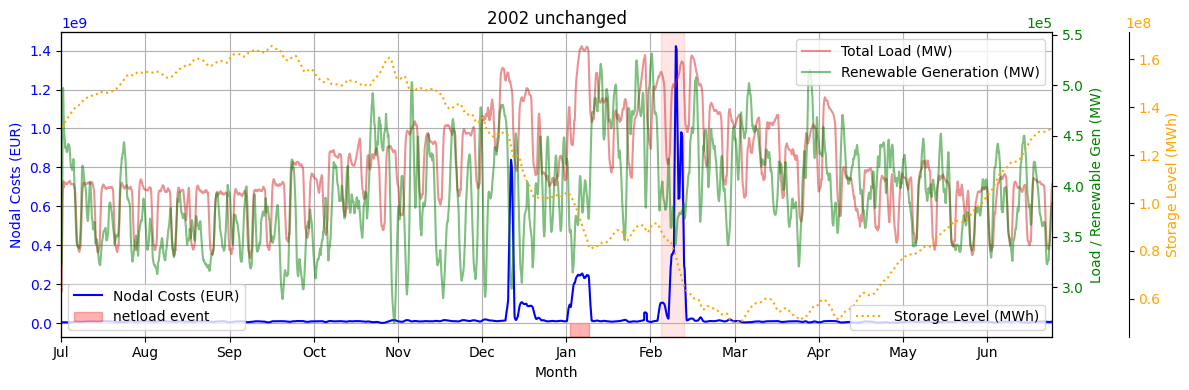

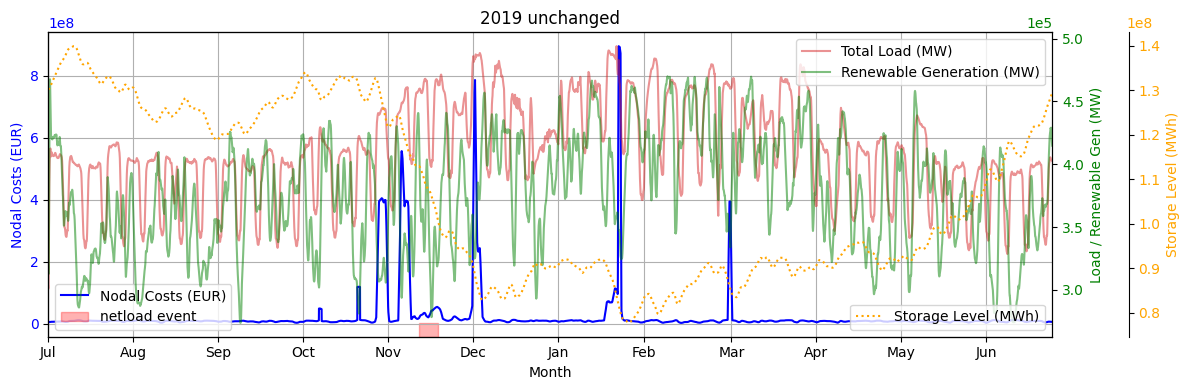

In [12]:
import os
import numpy as np
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
from matplotlib.dates import date2num

for i, filename in enumerate(sorted(os.listdir(network_folder))):
    if filename.endswith('.nc'):

        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)

        difficult_period = difficult_periods.loc[difficult_periods["file_name"] == filename, ["start", "end"]]
        netload_event = netload_events.loc[netload_events["file_name"] == filename, ["start", "end"]]

        # Initialize subplots (3 subplots, 1 column)
        fig, axs = plt.subplots(figsize=(12, 4), sharex=False)
        
        # Calculate nodal cost (marginal price * load)
        nodal_costs = n.buses_t["marginal_price"]* n.loads_t["p_set"]
        total_costs = nodal_costs.sum(axis="columns")
        
        # Calculate total load and non-dispatchable renewable generation
        # nd_generators = n.generators.index[n.generators.carrier.isin(['onwind', 'offwind-dc', 'offwind-ac', 'solar'])]
        # renewable_generation = n.generators_t.p[nd_generators].sum(axis=1)
        renewable_generation = n.generators_t.p.sum(axis=1)
        total_load = n.loads_t.p.sum(axis=1)
        
        # Calculate total storage level
        total_storage_level = n.storage_units_t.state_of_charge.sum(axis=1)
        
        # Smooth the data with a 1-day moving average
        smoothed_total_load = total_load.rolling(window='24H').mean()
        smoothed_renewable_generation = renewable_generation.rolling(window='24H').mean()
        smoothed_netload = smoothed_total_load-smoothed_renewable_generation
        smoothed_total_costs = total_costs.rolling(window='24H').mean()
        smoothed_total_storage_level = total_storage_level.rolling(window='24H').mean()
        
        # Create twin axes for the current subplot
        ax1 = axs
        ax2 = ax1.twinx()
        
        # Create a third y-axis for storage, using twinx again and adjusting its position
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 55))  # Offset the third axis
        
        # Plot nodal costs on the first y-axis (EUR) with the current year's color
        ax1.plot(smoothed_total_costs, label=f'Nodal Costs (EUR)', color='blue', linestyle='-')
        ax1.set_ylabel('Nodal Costs (EUR)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        # Plot total load and renewable generation on the second y-axis (MW)
        ax2.plot(smoothed_total_load, label=f'Total Load (MW)', color='tab:red', linestyle='-', alpha=0.5)
        ax2.plot(smoothed_renewable_generation, label=f'Renewable Generation (MW)', color='green', linestyle='-', alpha=0.5)
        ax2.set_ylabel('Load / Renewable Gen (MW)', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.ticklabel_format(axis='y', style='sci', scilimits=(0, 5))  # Apply scientific notation
        
        # Plot total storage level on the third y-axis
        ax3.plot(smoothed_total_storage_level, label=f'Storage Level (MWh)', color='orange', linestyle=':')
        ax3.set_ylabel('Storage Level (MWh)', color='orange')
        ax3.tick_params(axis='y', labelcolor='orange')
        ax3.ticklabel_format(axis='y', style='sci', scilimits=(0, 5))
        ax3.get_yaxis().get_offset_text().set_position((1.1,0))

        for key, value in type_mapping.items():
            if key in filename:
                type = value
                name = f'{filename[0:4]} {type}'
                shortname = f'{filename[0:4]}{key}'
                break
        
        # Set the title for each subplot
        ax1.set_title(f'{name}')
        
        # Set x-ticks to show only months in the bottom subplot
        month_labels = total_costs.index.strftime('%b')
        plt.xticks(ticks=total_costs.index[::744], labels=month_labels[::744], rotation=45)  # Adjust the frequency as needed
        
        # Set xlabel only for the bottom subplot
        ax1.set_xlabel('Month')

        # if not difficult_period.empty:
        #     ax1.axvspan(date2num(pd.Timestamp(difficult_period.iloc[0,0])), date2num(pd.Timestamp(difficult_period.iloc[0,1])), label="extreme event",color="red", alpha=0.1)
        # else:
        #     print(f"No difficult period found for file: {filename}")

        # if not netload_event.empty:
        #     ax1.axvspan(date2num(pd.Timestamp(netload_event.iloc[0,0])), date2num(pd.Timestamp(netload_event.iloc[0,1])), 0, 0.045, label="netload event",color="red", alpha=0.3)
        # else:
        #     print(f"No netload events found for file: {filename}")

        # Plot all difficult periods
        if not difficult_period.empty:
            for _, row in difficult_period.iterrows():
                ax1.axvspan(
                    date2num(pd.Timestamp(row[0])), 
                    date2num(pd.Timestamp(row[1])), 
                    label="extreme event" if _ == 0 else "",  # Add label only for the first one
                    color="red", 
                    alpha=0.1
                )
        else:
            print(f"No difficult period found for file: {filename}")
        
        # Plot all netload events
        if not netload_event.empty:
            for _, row in netload_event.iterrows():
                ax1.axvspan(
                    date2num(pd.Timestamp(row[0])), 
                    date2num(pd.Timestamp(row[1])), 
                    0, 
                    0.045, 
                    label="netload event",# if _ == 0 else "",  # Add label only for the first one
                    color="red", 
                    alpha=0.3
                )
        else:
            print(f"No netload events found for file: {filename}")
                
        # Add legends for all three axes
        ax1.legend(loc='lower left')
        ax2.legend(loc='upper right')
        ax3.legend(loc='lower right')#, bbox_to_anchor=(0.9, 0.85))
        
        # Enable grid for readability
        ax1.grid()
        ax1.margins(x=0)
        
        # Adjust layout to avoid overlap between subplots
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f'figures/timeseries_{shortname}.png')
        #plt.close()
        #plt.show()


## Plot: Short Timeseries

INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


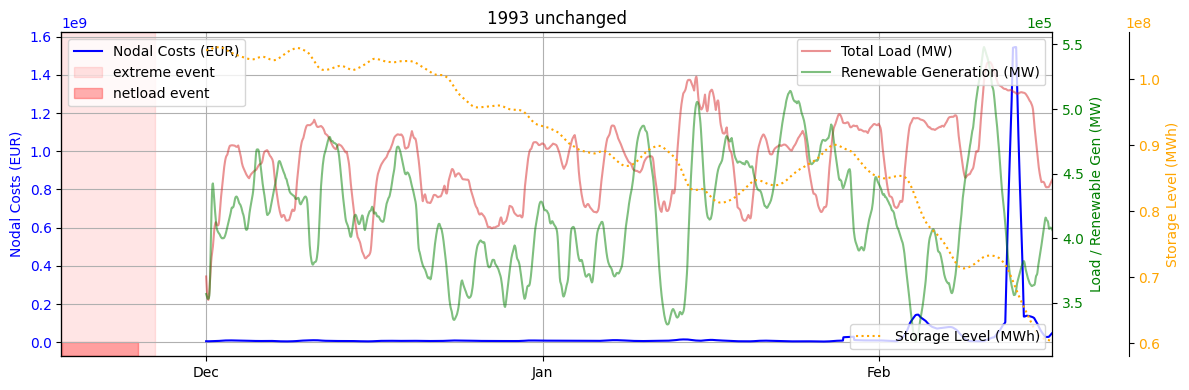

INFO:pypsa.io:Imported network 2002_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


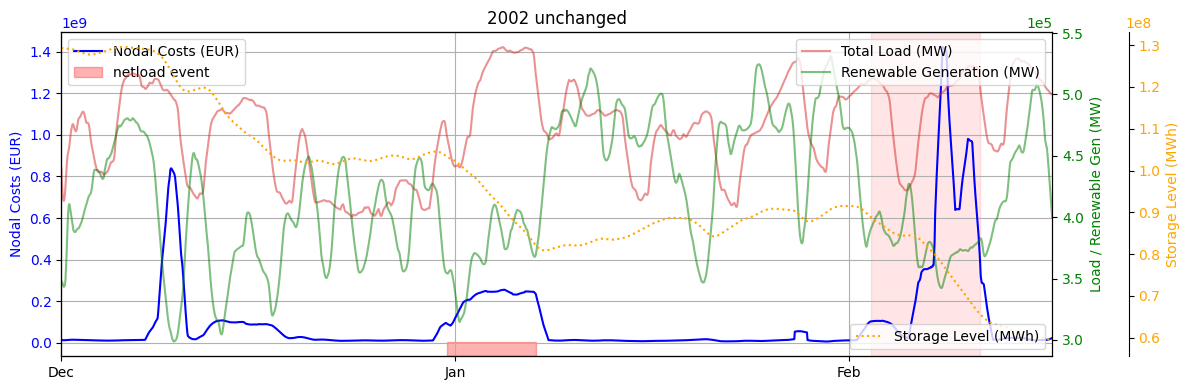

INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


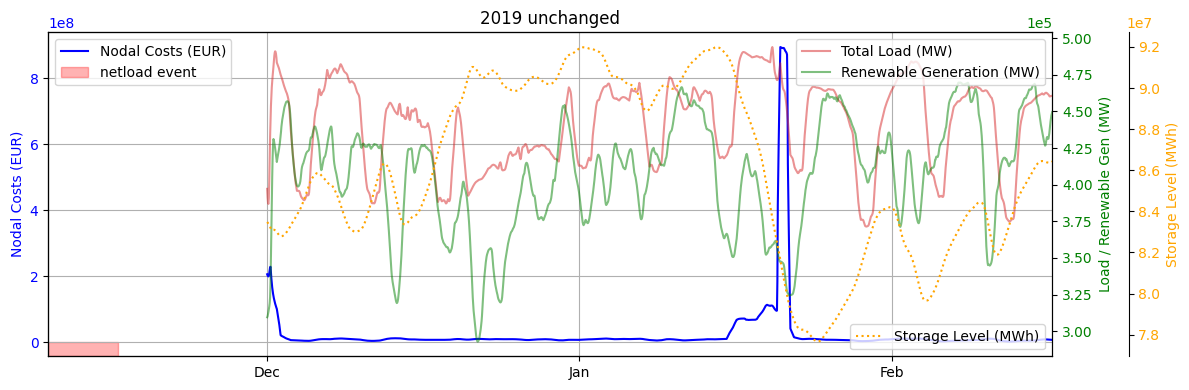

In [5]:
for i, filename in enumerate(sorted(os.listdir(network_folder))):
    if filename.endswith('.nc'):

        # Define the period: October to May
        #period = slice(f'{filename[0:4]}-10-01', f'{int(filename[0:4])+1}-03-31')
        period = slice(f'{filename[0:4]}-12-05', f'{int(filename[0:4])+1}-02-20')

        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)

        difficult_period = difficult_periods.loc[difficult_periods["file_name"] == filename, ["start", "end"]]
        netload_event = netload_events.loc[netload_events["file_name"] == filename, ["start", "end"]]

        # Initialize subplots (1 subplot)
        fig, axs = plt.subplots(figsize=(12, 4), sharex=False)

        # Calculate nodal cost (marginal price * load)
        nodal_costs = n.buses_t["marginal_price"] * n.loads_t["p_set"]
        total_costs = nodal_costs.sum(axis="columns").loc[period]

        # Calculate total load and non-dispatchable renewable generation
        renewable_generation = n.generators_t.p.sum(axis=1).loc[period]
        total_load = n.loads_t.p.sum(axis=1).loc[period]

        # Calculate total storage level
        total_storage_level = n.storage_units_t.state_of_charge.sum(axis=1).loc[period]

        # Smooth the data with a 1-day moving average
        smoothed_total_load = total_load.rolling(window='1D').mean()
        smoothed_renewable_generation = renewable_generation.rolling(window='1D').mean()
        smoothed_total_costs = total_costs.rolling(window='1D').mean()
        smoothed_total_storage_level = total_storage_level.rolling(window='1D').mean()

        # Create twin axes for the current subplot
        ax1 = axs
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 55))  # Offset the third axis

        # Plot nodal costs on the first y-axis (EUR)
        ax1.plot(smoothed_total_costs, label=f'Nodal Costs (EUR)', color='blue', linestyle='-')
        ax1.set_ylabel('Nodal Costs (EUR)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Plot total load and renewable generation on the second y-axis (MW)
        ax2.plot(smoothed_total_load, label=f'Total Load (MW)', color='tab:red', linestyle='-', alpha=0.5)
        ax2.plot(smoothed_renewable_generation, label=f'Renewable Generation (MW)', color='green', linestyle='-', alpha=0.5)
        ax2.set_ylabel('Load / Renewable Gen (MW)', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.ticklabel_format(axis='y', style='sci', scilimits=(0, 5))  # Apply scientific notation
        
        # Plot total storage level on the third y-axis
        ax3.plot(smoothed_total_storage_level, label=f'Storage Level (MWh)', color='orange', linestyle=':')
        ax3.set_ylabel('Storage Level (MWh)', color='orange')
        ax3.tick_params(axis='y', labelcolor='orange')
        ax3.ticklabel_format(axis='y', style='sci', scilimits=(0, 7))
        ax3.get_yaxis().get_offset_text().set_position((1.1,0))

        # Extract type and name information
        for key, value in type_mapping.items():
            if key in filename:
                type = value
                name = f'{filename[0:4]} {type}'
                shortname = f'{filename[0:4]}{key}'
                break

        # Set the title for each subplot
        ax1.set_title(f'{name}')

        # Adjust x-ticks for the filtered period
        month_labels = smoothed_total_costs.index.strftime('%b')
        plt.xticks(ticks=smoothed_total_costs.index[::744], labels=month_labels[::744], rotation=45)

        # Highlight difficult periods and netload events
        if not difficult_period.empty:
            for _, row in difficult_period.iterrows():
                ax1.axvspan(
                    date2num(pd.Timestamp(row[0])), 
                    date2num(pd.Timestamp(row[1])), 
                    label="extreme event" if _ == 0 else "",  # Add label only for the first one
                    color="red", 
                    alpha=0.1
                )
        if not netload_event.empty:
            ax1.axvspan(date2num(pd.Timestamp(netload_event.iloc[0, 0])),
                        date2num(pd.Timestamp(netload_event.iloc[0, 1])),
                        0, 0.045, label="netload event", color="red", alpha=0.3)

        # Add legends for all axes
        ax1.legend(loc='upper left', ncol=1)
        ax2.legend(loc='upper right')
        ax3.legend(loc='lower right')

        # Enable grid and adjust layout
        ax1.grid()
        ax1.margins(x=0)
        plt.tight_layout()

        # Save the plot
        #plt.savefig(f'figures/timeseries_focused_{shortname}.png')
        plt.show()

## Plot: Europe wide overview of extreme events

INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2002_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


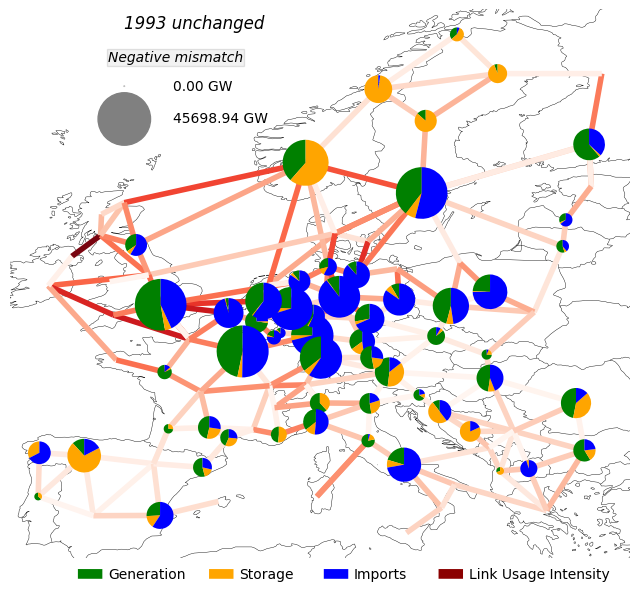

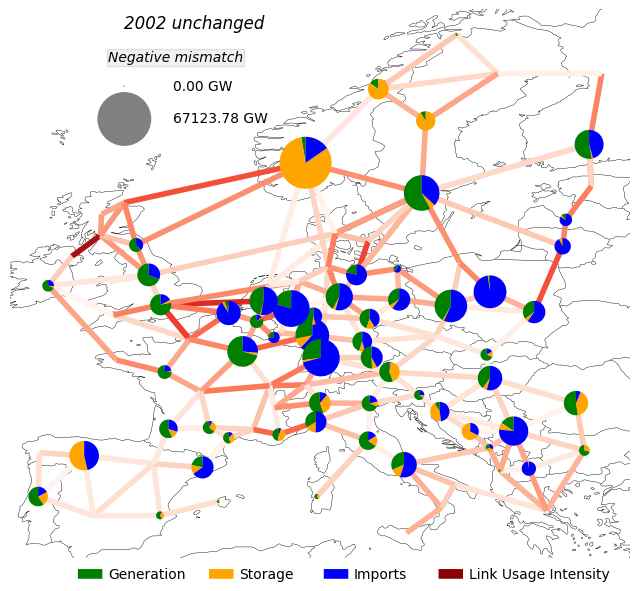

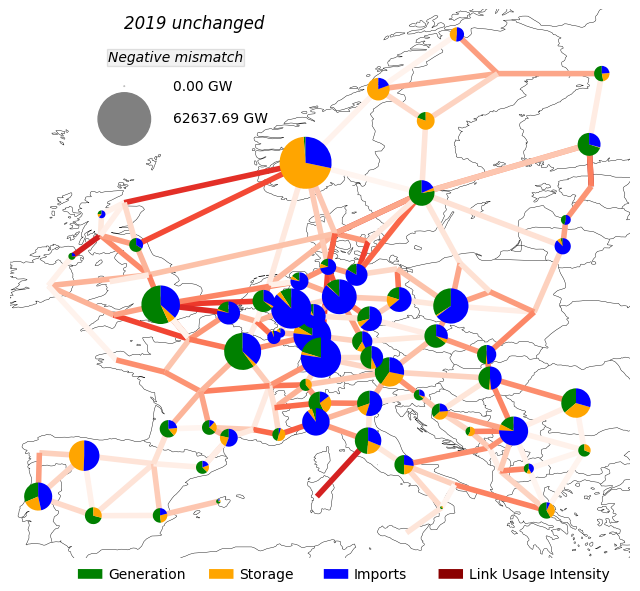

In [8]:
for i, filename in enumerate(sorted(os.listdir(network_folder))):
    if filename.endswith('.nc'):

        # Define the period: October to May
        period = slice(f'{filename[0:4]}-10-01', f'{int(filename[0:4])+1}-03-31')

        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)
        num_hours = n.loads_t.p_set.loc[period].shape[0]
        
        # Calculate total load for each bus
        total_load_per_bus = n.loads_t.p_set.loc[period].sum(axis=0)
        
        # Calculate total generation for each bus
        total_generation_per_bus = n.generators_t.p.loc[period].sum(axis=0).groupby([n.generators["bus"]]).sum()
        
        # Calculate total storage for each bus (charge + discharge)
        total_storage_per_bus = n.storage_units_t.p_dispatch.loc[period].sum(axis=0).groupby([n.storage_units["bus"]]).sum()
        
        # Calculate total imports for each bus (imported power through lines or links)
        total_imports_per_bus = pd.Series(0.0, index=n.buses.index)
        for idx, line in n.lines.iterrows():
            bus0 = line['bus0']
            bus1 = line['bus1']
            total_imports_per_bus[bus0] += n.lines_t.p0.loc[period, idx].sum()  # Flow at bus0
            total_imports_per_bus[bus1] += n.lines_t.p1.loc[period, idx].sum()  # Flow at bus1
        
        for idx, link in n.links.iterrows():
            bus0 = link['bus0']
            bus1 = link['bus1']
            total_imports_per_bus[bus0] += n.links_t.p0.loc[period, idx].sum()  # Flow at bus0
            total_imports_per_bus[bus1] += n.links_t.p1.loc[period, idx].sum()  # Flow at bus1
        
        # Prepare the pie chart for each bus
        fractions = {}
        for bus in n.buses.index:
            load = total_load_per_bus[bus]
            generation = total_generation_per_bus[bus]
            storage = total_storage_per_bus[bus]
            imports = np.abs(np.minimum(0, total_imports_per_bus[bus]))
            
            if load != 0:
                generation_fraction = generation / load
                storage_fraction = storage / load
                imports_fraction = imports / load
            else:
                generation_fraction = storage_fraction = imports_fraction = 0
        
            fractions[bus] = [generation_fraction, storage_fraction, imports_fraction]
        
        
        # Calculate the summed mismatch over the period for each bus
        mismatch = n.loads_t.p_set.loc[period].sum(axis=0) - n.generators_t.p.loc[period].sum(axis=0).groupby([n.generators["bus"]]).sum()
        # Get the bus sizes based on the summed mismatch (scale appropriately)
        bus_sizes = np.maximum(1e-5, mismatch) # Scale to fit your desired plot size
        #bus_sizes_norm = np.maximum(1e-5,(bus_sizes - bus_sizes.min()) / (bus_sizes.max() - bus_sizes.min()))
        
        # Calculate the ratio of used to nominal transmission capacity for each line
        line_ratio = (n.lines_t.p0.loc[period].sum(axis=0).abs() / (n.lines.s_nom_opt * num_hours)) #.clip(0, 1)  # Clip to ensure values are between 0 and 1
        link_ratio = (n.links_t.p0.loc[period].sum(axis=0).abs() / (n.links.p_nom_opt * num_hours))
        # Map transmission ratios to colors using Reds colormap
        line_colors = pd.Series(
            [cm.Reds(value) for value in line_ratio], index=n.lines.index
        )
        link_colors = pd.Series(
            [cm.Reds(value) for value in link_ratio], index=n.links.index
        )
        
        # Create the plot using Cartopy
        fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8, 8))
        
        # Plot the network (this will display the buses, lines, etc.)
        n.plot(ax=ax, bus_sizes=1e-6, line_widths=4, line_colors=line_colors, link_widths=4, link_colors=link_colors)
        
        # Set the extent of the map to a region of interest (optional to zoom in)
        #ax.set_extent([min(n.buses['x']), max(n.buses['x']), min(n.buses['y']), max(n.buses['y'])], crs=ccrs.PlateCarree())
        
        # Plot pie charts at each bus location using inset_axes
        for bus, (generation_fraction, storage_fraction, imports_fraction) in fractions.items():
            # Get the bus location (lat, lon)
            lat, lon = n.buses.loc[bus, ["x", "y"]]
            
            # Data for the pie chart: [generation, storage, imports]
            sizes = [generation_fraction, storage_fraction, imports_fraction]
            colors = ['green', 'orange', 'blue']
        
            # Transform the coordinates from geo to figure coordinates using Cartopy's projection
            lonr, latr = ax.projection.transform_point(lon, lat, ccrs.PlateCarree())
        
            # Create the inset_axes for the pie chart with absolute width and height (not percentage)
            ax_sub = inset_axes(ax, width=0.05, height=0.05, loc="center", bbox_to_anchor=(lat, lon),
                                bbox_transform=ax.transData, borderpad=0)
            
            # Plot the pie chart inside the inset_axes
            scaling_factor = 13 / (bus_sizes.max()**0.5)
            wedges, texts = ax_sub.pie(sizes, colors=colors, startangle=90, radius=bus_sizes[bus]**0.5*scaling_factor)  # **0.5 is scaling build into n.plot
        
            # Ensure the pie chart has equal aspect ratio
            ax_sub.set_aspect("equal")
        
        ax.annotate('Generation', xy=(-6, 35.25), xytext=(-4, 35), fontsize=10,
                    arrowprops=dict(color='green', arrowstyle='-', linewidth=7, capstyle='butt'),
            transform=ccrs.PlateCarree())
        ax.annotate('Storage', xy=(2, 35.25), xytext=(4, 35), fontsize=10,
                    arrowprops=dict(color='orange', arrowstyle='-', linewidth=7, capstyle='butt'),
            transform=ccrs.PlateCarree())
        ax.annotate('Imports', xy=(9, 35.25), xytext=(11, 35), fontsize=10,
                    arrowprops=dict(color='blue', arrowstyle='-', linewidth=7, capstyle='butt'),
            transform=ccrs.PlateCarree())
        ax.annotate('Link Usage Intensity', xy=(16, 35.25), xytext=(18, 35), fontsize=10,
                    arrowprops=dict(color='darkred', arrowstyle='-', linewidth=7, capstyle='butt'),
            transform=ccrs.PlateCarree())
        
        # Extract type and name information
        for key, value in type_mapping.items():
            if key in filename:
                type = value
                name = f'{filename[0:4]} {type}'
                shortname = f'{filename[0:4]}{key}'
                break
        ax.text(
            -3, 68.5,  # Example longitude, latitude
            f'{name}', 
            style='oblique',
            fontsize=12,
            #bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 1},
            transform=ccrs.PlateCarree()  # Ensure text is plotted in geographic coordinates
        )
        
        # Add the circles to the axis
        ax.add_patch(Circle((-3, 65), 1e-2, color='grey', alpha=1)) #, ec='black'
        ax.add_patch(Circle((-3, 63), 1.6, color='grey', alpha=1))
        ax.text(0, 63, f'{bus_sizes.max() * 1e-3:.2f} GW', va='center')
        ax.text(0, 65, f'{bus_sizes.min()* 1e-3:.2f} GW', va='center')
        ax.text(-4, 66.5, 'Negative mismatch', style='italic',
            bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 1},
            transform=ccrs.PlateCarree() 
        )
        
        # Add title and show the plot
        #plt.show()
        plt.savefig(f'figures/Extreme_Event_Map_{shortname}.png')


## Plot: Overall System Costs

INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2002_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


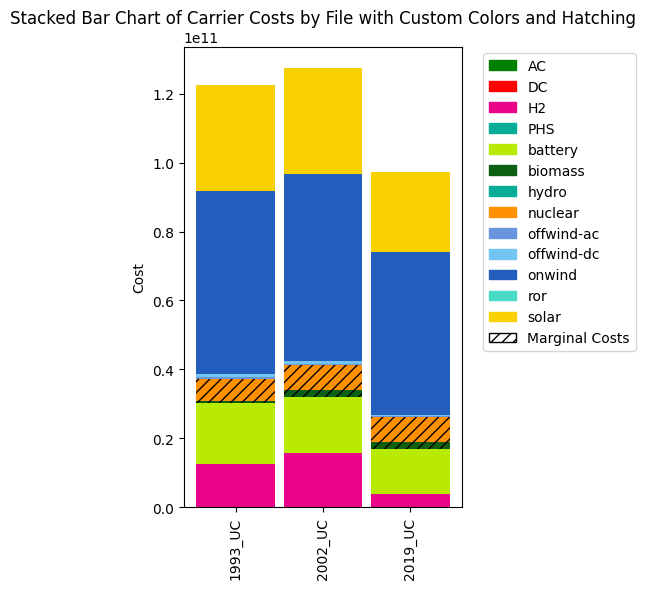

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pypsa
import matplotlib.patches as mpatches

# Store data for all files
all_costs = []
nrFiles = 0

for filename in sorted(os.listdir(network_folder)):
    if filename.endswith('.nc'):
        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)

        # Calculate costs
        storage_capital_costs = (n.storage_units['capital_cost'] * 
                                 (n.storage_units['p_nom_opt'] - n.storage_units['p_nom'])).groupby(n.storage_units['carrier']).sum()
        storage_marginal_costs = (n.storage_units['marginal_cost'] * 
                                  n.storage_units_t.p.sum(axis=0)).groupby(n.storage_units['carrier']).sum()
        generators_capital_costs = (n.generators['capital_cost'] * 
                                    (n.generators['p_nom_opt'] - n.generators['p_nom'])).groupby(n.generators['carrier']).sum()
        generators_marginal_costs = (n.generators['marginal_cost'] * 
                                     n.generators_t.p.sum(axis=0)).groupby(n.generators['carrier']).sum()
        AC_line_costs = n.lines.capital_cost.sum()
        DC_link_costs = n.links.capital_cost.sum()

        # Combine costs into a single DataFrame
        storage_costs = pd.DataFrame({
            'Capital': storage_capital_costs,
            'Marginal': storage_marginal_costs
        })
        generator_costs = pd.DataFrame({
            'Capital': generators_capital_costs,
            'Marginal': generators_marginal_costs
        })

        carrier_costs = (storage_costs.add(generator_costs, fill_value=0))
        carrier_costs.loc['AC'] = {'Capital': AC_line_costs, 'Marginal': 0}
        carrier_costs.loc['DC'] = {'Capital': DC_link_costs, 'Marginal': 0}

        # Add colors
        bar_colors = n.carriers['color']
        extra_colors = pd.Series({'DC': 'red', 'AC': 'green'})
        bar_colors = pd.concat([bar_colors, extra_colors])

        # Extract type and name information
        for key, value in type_mapping.items():
            if key in filename:
                type = value
                name = f'{filename[0:4]} {type}'
                shortname = f'{filename[0:4]}{key}'
                break
        
        # Store costs and colors
        for carrier, row in carrier_costs.iterrows():
            for cost_type, value in row.items():
                all_costs.append({
                    'File': shortname,
                    'Carrier': carrier,
                    'Cost Type': cost_type,
                    'Value': value,
                    'Color': bar_colors.get(carrier, 'gray'),
                    'Hatch': '///' if cost_type == 'Marginal' else None
                })
        
        nrFiles += 1

# Convert accumulated costs to a DataFrame
all_costs_df = pd.DataFrame(all_costs)

# Pivot the data for stacked bar chart
pivoted_costs = all_costs_df.pivot_table(
    index='File',
    columns=['Carrier', 'Cost Type'],
    values='Value',
    fill_value=0
)

# Plot stacked bars
fig, ax = plt.subplots(figsize=((0.9*nrFiles), 6))
bar_width = 0.9
x = np.arange(len(pivoted_costs.index))  # One bar per file

# Store unique legend handles for capital costs
legend_handles = {}
# Iterate through carriers and cost types for stacking
y_offset = np.zeros(len(pivoted_costs.index))
for i, ((carrier, cost_type), values) in enumerate(pivoted_costs.items()):
    # Determine color and hatching
    color = all_costs_df.loc[
        (all_costs_df['Carrier'] == carrier) & (all_costs_df['Cost Type'] == cost_type),
        'Color'
    ].iloc[0]
    hatch = '///' if cost_type == 'Marginal' else None
    
    # Plot bar segment
    ax.bar(x, values, bar_width, bottom=y_offset, label=f'{carrier} {cost_type}', color=color, hatch=hatch)
    y_offset += values  # Update offset for stacking

    # Add legend handles for capital costs only
    if cost_type == 'Capital' and carrier not in legend_handles:
        legend_handles[carrier] = mpatches.Patch(color=color, label=f'{carrier}')

# Add single hatching legend for marginal costs
marginal_patch = mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Marginal Costs')

# Add labels and legend
#ax.set_title('Stacked Bar Chart of Carrier Costs by File with Custom Colors and Hatching')
ax.set_ylabel('Total System Cost (EUR)')
ax.set_xticks(x)
ax.set_xticklabels(pivoted_costs.index, rotation=90)#, ha='right')

# Combine handles into the legend
ax.legend(handles=list(legend_handles.values()) + [marginal_patch], loc='upper left', bbox_to_anchor=(1.05, 1))


plt.tight_layout()
#plt.show()
plt.savefig(f'figures/Total_System_Cost_ALL.png')


## Plot: Extreme and Netload event Overview

INFO:pypsa.io:Imported network 1993_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2002_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units
INFO:pypsa.io:Imported network 2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


No difficult period found for file: 2019_181_90m_c1.25_Co2L0.0-1H_UC_solved.nc


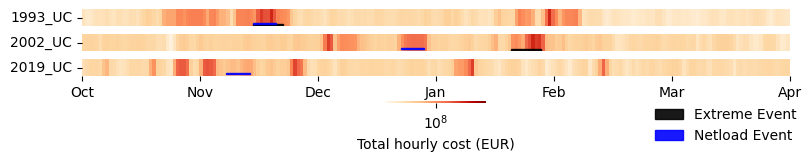

In [25]:
# Set the directory containing your .nc files
network_folder = 'networks/outputs/solved/UC'

# Load auxiliary CSVs
difficult_periods = pd.read_csv(f"{network_folder}/difficult_periods.csv")
netload_events = pd.read_csv(f"{network_folder}/netload_events.csv")

# Generate the date range for consistent x-axis ticks
num_days = 366  # Leap year (adjust if needed)
start_date = "2022-07-01"
dates = pd.date_range(start=start_date, periods=num_days, freq="D")
october_start = dates.get_loc("2022-10-01")
april_end = dates.get_loc("2023-04-30")
xticks = pd.date_range(start="2022-10-01", end="2023-04-30", freq="MS")
xtick_labels = xticks.strftime("%b")

# Initialize the figure for all heatmaps
num_years = sum(1 for f in os.listdir(network_folder) if f.endswith('.nc'))
fig, axes = plt.subplots(num_years, 1, figsize=(8, 0.5*num_years), sharex=True, constrained_layout=True)

# If there is only one subplot, ensure axes is iterable
if num_years == 1:
    axes = [axes]

# Process and plot each year inside the loop
for i, filename in enumerate(sorted(os.listdir(network_folder))):
    if filename.endswith('.nc'):
        network_path = os.path.join(network_folder, filename)
        n = pypsa.Network(network_path)

        difficult_period = difficult_periods.loc[difficult_periods["file_name"] == filename, ["start", "end"]]
        netload_event = netload_events.loc[netload_events["file_name"] == filename, ["start", "end"]]

        # Calculate total costs
        nodal_costs = n.buses_t["marginal_price"] * n.loads_t["p_set"]
        total_costs = nodal_costs.sum(axis="columns")
        total_costs = total_costs.rolling(window='1D').mean()

        # Extract timestamp and cost
        data = pd.DataFrame({
            "timestamp": total_costs.index,
            "cost": total_costs.values
        })

        # Convert timestamp to datetime
        data["timestamp"] = pd.to_datetime(data["timestamp"])

        # Define "fiscal year" July-to-June
        data["month"] = data["timestamp"].dt.month
        data["fiscal_year"] = np.where(
            data["month"] >= 7,
            data["timestamp"].dt.year,
            data["timestamp"].dt.year - 1
        )
        data["dayofyear"] = (data["timestamp"] - pd.to_datetime(data["fiscal_year"].astype(str) + "-07-01")).dt.days

        # Pivot data for heatmap
        heatmap_data = data.pivot_table(
            index="fiscal_year",
            columns="dayofyear",
            values="cost",
            aggfunc="mean"
        )

        # Plot heatmap for this year
        sns.heatmap(
            heatmap_data,
            ax=axes[i],
            norm=LogNorm(vmin=1e6, vmax=1e10),
            cmap="OrRd",
            cbar=(i == num_years - 1),
            cbar_kws={'label': 'Total hourly cost (EUR)', 'orientation': 'horizontal', 'shrink': 0.6, 'aspect': 40},
            linewidths=0
        )

        # Format the subplot
        fiscal_year_label = f"{data['fiscal_year'].iloc[0]}/{data['fiscal_year'].iloc[0] + 1}"
        #axes[i].set_title(f"{fiscal_year_label}_UC", fontsize=12, ha='center', rotation=0)
        axes[i].set_xlim(october_start, april_end)
        axes[i].set_xticks(np.linspace(october_start, april_end, len(xticks)))
        axes[i].set_xticklabels(xtick_labels, rotation=0)

        # Hide the x-axis ticks for all except the last subplot
        if i != num_years - 1:
            axes[i].tick_params(axis='x', which='both', length=0)  # Remove x-axis ticks
            axes[i].set_xticklabels([])  # Remove x-axis labels
        # Hide y-axis label for clarity
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")

        # Extract type and name information
        for key, value in type_mapping.items():
            if key in filename:
                type = value
                name = f'{filename[0:4]} {type}'
                shortname = f'{filename[0:4]}{key}'
                break

        axes[i].set_yticklabels([f"{shortname}"], rotation=0, va='center')

        # if not difficult_period.empty:
        #     start_dayofyear = (
        #         pd.Timestamp(difficult_period.iloc[0, 0]).tz_localize(None) - 
        #         pd.Timestamp(f"{data['fiscal_year'].iloc[0]}-07-01")
        #     ).days
        #     end_dayofyear = (
        #         pd.Timestamp(difficult_period.iloc[0, 1]).tz_localize(None) - 
        #         pd.Timestamp(f"{data['fiscal_year'].iloc[0]}-07-01")
        #     ).days
        
        #     axes[i].axvspan(start_dayofyear, end_dayofyear, 0, 0.1, label="Difficult Period", color="black", alpha=0.9)
        # else:
        #     print(f"No difficult period found for file: {filename}")

        if not difficult_period.empty:
            for _, row in difficult_period.iterrows():
                start_dayofyear = (
                    pd.Timestamp(row[0]).tz_localize(None) - 
                    pd.Timestamp(f"{data['fiscal_year'].iloc[0]}-07-01")
                ).days
                end_dayofyear = (
                    pd.Timestamp(row[1]).tz_localize(None) - 
                    pd.Timestamp(f"{data['fiscal_year'].iloc[0]}-07-01")
                ).days
        
                # Add a label only for the first difficult period to avoid duplicate legends
                axes[i].axvspan(
                    start_dayofyear, 
                    end_dayofyear, 
                    0, 
                    0.1, 
                    label="Difficult Period" if _ == 0 else "", 
                    color="black", 
                    alpha=0.9
                )
        else:
            print(f"No difficult period found for file: {filename}")

        if not netload_event.empty:
            start_dayofyear = (
                pd.Timestamp(netload_event.iloc[0, 0]).tz_localize(None) - 
                pd.Timestamp(f"{data['fiscal_year'].iloc[0]}-07-01")
            ).days
            end_dayofyear = (
                pd.Timestamp(netload_event.iloc[0, 1]).tz_localize(None) - 
                pd.Timestamp(f"{data['fiscal_year'].iloc[0]}-07-01")
            ).days
        
            axes[i].axvspan(start_dayofyear, end_dayofyear, ymin=0.1, ymax=0.2, label="Netload Event", color="blue", alpha=0.9)
        else:
            print(f"No netload events found for file: {filename}")

legend_elements = [
    Patch(facecolor='black', edgecolor='black', label='Extreme Event', alpha=0.9),
    Patch(facecolor='blue', edgecolor='blue', label='Netload Event', alpha=0.9)
]

# Add the legend to the last axis
fig.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.9, 0),
    ncol=1,
    frameon=False
)

#plt.show()
plt.savefig(f'figures/Events_Overview_ALL.png')

# beide plots für alles aufm server laufen lassen

In [55]:
print(axes[-1].get_xlim(), axes[-1].get_ylim())

(92.0, 303.0) (1.0, 0.0)
